In [14]:
# imports
import numpy as np

# Dynamic Programming Project 2023
---
This notebook solves the project presented in the `model.py` file

ChatGPT has the following answer to the question:
- *How would you extend a consumption savings model in a dynamic programming course project?*

"Extending a consumption savings model in a dynamic programming course project can involve adding additional features to the basic model or modifying the assumptions of the model to make it more realistic. Here are a few ideas for extending a consumption savings model in a dynamic programming project:

**Add constraints**: One way to make the consumption savings model more realistic is to add constraints to the optimization problem. For example, you could add a borrowing constraint to the model to limit the amount of debt that households can take on. This would affect their consumption and savings decisions, as they would have to balance their desire to consume with their ability to borrow.

**Incorporate uncertainty**: Another way to extend the model is to incorporate uncertainty into the decision-making process. You could add a stochastic element to the model, such as a random income shock, to simulate the uncertainty that households face in the real world. This would require you to use dynamic programming methods that are suited to stochastic optimization problems.

**Consider heterogeneous agents**: A more complex extension would be to consider the heterogeneity of agents in the model. You could assume that households have different preferences or abilities to save, and that they face different constraints. This would require you to use dynamic programming methods that can handle optimization problems with multiple agents.

**Analyze policy interventions**: Finally, you could use the consumption savings model to analyze the effects of policy interventions on households. For example, you could simulate the effects of a tax cut or a change in interest rates on household consumption and savings decisions. This would allow you to evaluate the effectiveness of different policy interventions in achieving their intended goals.

Overall, extending a consumption savings model in a dynamic programming project requires careful consideration of the features and assumptions of the model and how they can be modified to capture real-world phenomena. It also requires knowledge of dynamic programming methods and how to apply them to solve optimization problems."

## Setup

In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from EconModel import EconModelClass, jit 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Baseline Consumption Savings Model

We use `consav_labor_model_copy` as our testing model atm.

In [16]:
from consav_labor_model_copy import ConSavModelClass


### Value Function Iteration

In [17]:
model_vfi = ConSavModelClass()

par = model_vfi.par
sol = model_vfi.sol
sim = model_vfi.sim

model_vfi.solve(do_print=True,algo='vfi')

iteration    0 solved in 36.2 secs  [max abs. diff. 2.06e+00]
iteration    1 solved in 0.4 secs   [max abs. diff. 1.93e+00]
iteration    2 solved in 0.3 secs   [max abs. diff. 1.81e+00]
iteration    3 solved in 0.3 secs   [max abs. diff. 1.70e+00]
iteration    4 solved in 0.3 secs   [max abs. diff. 1.60e+00]
iteration    5 solved in 0.3 secs   [max abs. diff. 1.51e+00]
iteration    6 solved in 0.3 secs   [max abs. diff. 1.42e+00]
iteration    7 solved in 0.3 secs   [max abs. diff. 1.34e+00]
iteration    8 solved in 0.3 secs   [max abs. diff. 1.27e+00]
iteration    9 solved in 0.3 secs   [max abs. diff. 1.20e+00]
iteration  100 solved in 0.2 secs   [max abs. diff. 1.92e-02]
iteration  200 solved in 0.2 secs   [max abs. diff. 3.20e-04]
iteration  300 solved in 0.2 secs   [max abs. diff. 5.40e-06]
iteration  400 solved in 0.2 secs   [max abs. diff. 9.11e-08]
iteration  455 solved in 0.2 secs   [max abs. diff. 9.64e-09]
model solved in 2.0 mins 21 secs


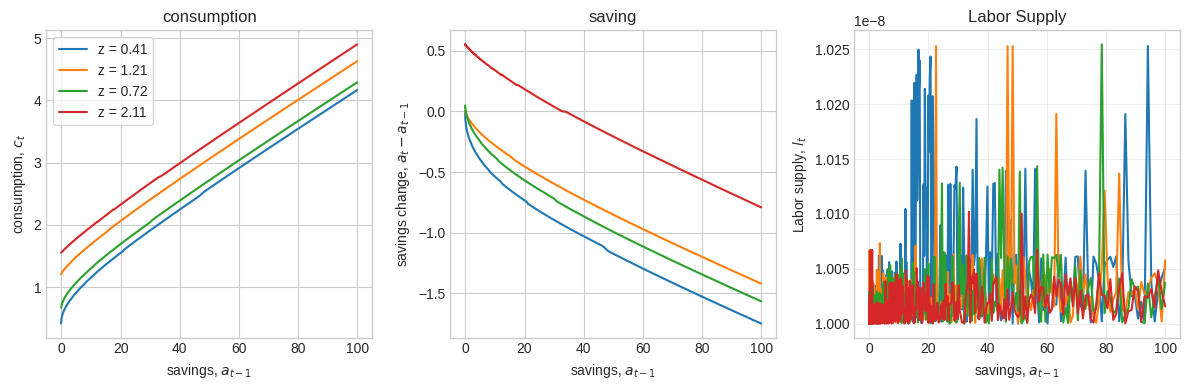

In [18]:
fig = plt.figure(figsize=(12,4),dpi=100)

I = par.a_grid < 500

# a. consumption
ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z,z in enumerate(par.z_grid):
    if i_z%3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I],sol.c[i_z,:],label=f'z = {z:.2f}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z,z in enumerate(par.z_grid):
    if i_z%3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I],sol.a[i_z,:]-par.a_grid[I],label=f'z = {z:.2f}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings change, $a_{t}-a_{t-1}$')

# Labor Supply

#fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,3,3)

ax.set_title(f'Labor Supply')

for i_z,z in enumerate(par.z_grid):
    if i_z%3 == 0 or i_z == par.Nz-1:
        ax.plot(par.a_grid[I],sol.ell[i_z,:],label=f'z = {z:.2f}')

#ax.plot(par.a_grid,sol.ell[0,i_z,I])

ax.grid(visible=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('Labor supply, $l_t$')

# ax.legend(frameon=True)  # Add legend to the plot

fig.tight_layout()

### Endogenous Grid Method

In [19]:
model_egm = model_vfi.copy()

In [20]:
model_egm.solve(do_print=True,algo='egm')

iteration    0 solved in 3.2 secs   [max abs. diff. 4.96e+01]
iteration    1 solved in 0.0 secs   [max abs. diff. 1.67e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 8.35e+00]
iteration    3 solved in 0.0 secs   [max abs. diff. 5.02e+00]
iteration    4 solved in 0.0 secs   [max abs. diff. 3.35e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 2.39e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 1.80e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 1.40e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 1.12e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 9.15e-01]
iteration  100 solved in 0.0 secs   [max abs. diff. 3.28e-03]
iteration  200 solved in 0.0 secs   [max abs. diff. 3.03e-06]
iteration  269 solved in 0.0 secs   [max abs. diff. 9.93e-09]
model solved in 3.6 secs


### Compare Solution Methods

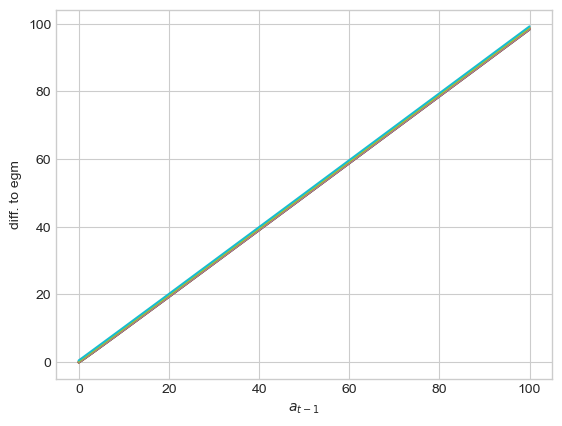

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i_z in range(par.Nz):
    ax.plot(par.a_grid,model_vfi.sol.a[i_z,:])
    
ax.set_xlabel('$a_{t-1}$');
ax.set_ylabel('diff. to egm');